# Holdouts Evaluation - Amazon Digital Music
sample from 2014-06 until 2016-11 with 6M cold start incl.

In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

# imports

In [2]:
import pandas as pd 
import joblib

from dataset_evaluation_utils import get_namepaths
from data_utils import load_data_print_info

from data import ImplicitData, getBucketsHoldouts
from eval_implicit import EvaluateHoldouts, EvalPrequential 
from recommenders_implicit import ISGD

from plot_utils import recall_heatmap
from data_utils.transfer_learning_scores import *

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

# import plotly.offline as py
# pd.options.plotting.backend = "plotly"
# py.init_notebook_mode() # graphs charts inline (IPython).

a4_dims = (11.7, 8.27)

In [3]:
sample_1516 = 'sample_2014-06_until_2016-11+cold_start'

In [4]:
def run_evaluate(data,
                 user_col,
                 item_col, 
                 interval_type, 
                 intervals_path, 
                 use_data_unique_users,
                 frequent_users_path,
                 buckets_path,
                 holdouts_path,
                 cold_start_buckets,
                 to_grid_search,
                 num_factors,
                 num_iter,
                 learn_rate,
                 regularization,
                 random_seed,
                 results_matrix_path,
                 recall_heatmap_title,
                 recall_heatmap_path,
                 incrementalTraining_time_record_path,
                 evaluateHoldouts_time_record_path):
    '''
    
        interval_type: string | M, Q, S

    '''

    
    frequent_users = joblib.load(frequent_users_path)
    frequent_users_idx = None

    if interval_type=='Q':
        frequent_users_idx = 1
        interval_type ='QS'
        intervals = joblib.load(intervals_path)

        if use_data_unique_users:
            frequent_users = (frequent_users[0], data['user_id'].unique(), frequent_users[2])

    elif interval_type=='S':
        frequent_users_idx = 2
        interval_type ='QS'
        intervals = joblib.load(intervals_path)

        if use_data_unique_users:
            frequent_users = (frequent_users[0], frequent_users[1], data['user_id'].unique())

    else:
        # assumes monthly interval
        interval_type = 'M'
        frequent_users_idx = 0 
        intervals = None   
        
        if use_data_unique_users:
            frequent_users = (data['user_id'].unique(), frequent_users[1], frequent_users[2])
        
        

    print('\nSTAGE -> getBucketsHoldouts')
    buckets, holdouts = getBucketsHoldouts( data = data,
                                            user_col = user_col,
                                            item_col = item_col,
                                            frequent_users = frequent_users[frequent_users_idx],
                                            interval_type = interval_type,
                                            intervals = intervals, 
                                            cold_start_buckets = cold_start_buckets)
    

    joblib.dump(buckets, buckets_path)
    joblib.dump(holdouts, holdouts_path)
    
    print('\nBucket size, number of users, number of items\n', [(b.size, len(b.userset), len(b.itemset)) for b in buckets])
    print('Holdouts size, number of users, number of items\n', [(h.size, len(h.userset), len(h.itemset)) for h in holdouts])


    print('\n\nSTAGE -> to_grid_search')
    if to_grid_search:
        prop = 0.05 
        hp_sample = data.iloc[:round( data.shape[0]*prop )]
        stream = ImplicitData(hp_sample[user_col], hp_sample[item_col]) 
        grid, results = grid_search(model = ISGD, 
                                    stream = stream, 
                                    random_seed = random_seed, 
                                    interleaved = 100 )
        num_factors, num_iter, learn_rate, regularization, _ = grid[ np.argmax( results ) ]

    print('num_factors, num_iter, learn_rate, regularization\n', (num_factors, num_iter, learn_rate, regularization))

    print('\n\nSTAGE -> ISGD model')
    empty_stream = ImplicitData([], [])
    model = ISGD(empty_stream, 
                num_factors, 
                num_iter, 
                learn_rate = learn_rate,
                u_regularization = regularization,
                i_regularization = regularization,
                random_seed = random_seed)
    


    print('\n\nSTAGE -> EvaluateHoldouts')
    eval = EvaluateHoldouts(model = model,
                            buckets = buckets,
                            holdouts = holdouts)
    
    eval.Train_Evaluate(N_recommendations=20, exclude_known_items=True, default_user='none')

    rm = eval.results_matrix
    rm_df = pd.DataFrame(rm)
    rm_df.to_csv(results_matrix_path, index=False)
    print(rm_df)

    recall_heatmap( rm_df,
                    round_point = 4,
                    title = recall_heatmap_title,
                    filepath = recall_heatmap_path) 
    

    print('\n\nstage -> metrics')    
    arecall = avg_recall(rm_df)
    BWT_lr, meanBWT_lr = compute_BWT_lopes_ranzato(rm_df)
    BWT_r, meanBWT_r = compute_BWT_rodrigues(rm_df)
    FWT_r = compute_FWT_rodrigues(rm_df)

    print('avg recall', arecall.round(6))
    print('BWT (v. Lopez-Paz e Ranzato GEM 2017), meanBWT', (BWT_lr, meanBWT_lr))
    print('BWT (v. Díaz-Rodriguez et al. 2018), meanBWT', (BWT_r, meanBWT_r))
    print('FWT', FWT_r.round(6))

    joblib.dump(eval.IncrementalTraining_time_record, incrementalTraining_time_record_path)
    joblib.dump(eval.EvaluateHoldouts_time_record, evaluateHoldouts_time_record_path)


    return rm_df, arecall, (BWT_lr, meanBWT_lr), (BWT_r, meanBWT_r), FWT_r


def print_heatmap(results_matrix_path, recall_heatmap_title, filepath=False):
    rm_df = pd.read_csv(results_matrix_path)
    recall_heatmap( rm_df,
                    round_point = 4,
                    title = recall_heatmap_title,
                    filepath = filepath) 


In [5]:
sample_year_month = [('2014-06', '%Y-%m'), ('2016-11', '%Y-%m')]
interval_type = 'S'
dump_filename ='amazon_digmusic_dump'
use_data_unique_users = False
frequent_users_thr = 0.75
cold_start_buckets = 1
to_grid_search = False
num_factors = 100
num_iter = 6
learn_rate = 0.1
regularization = 0.1
random_seed = 10


namepaths = get_namepaths(data_name = '_amazon_digitalmusic',
                          data_print_name = 'Amazon Digital Music',
                          sample_year_month = sample_year_month,
                          interval_type = interval_type,
                          dump_filename = dump_filename,
                          frequent_users_thr = frequent_users_thr,
                          cold_start_buckets = cold_start_buckets,
                          use_data_unique_users = use_data_unique_users,
                          to_grid_search = to_grid_search,
                          num_factors = num_factors,
                          num_iter = num_iter,
                          learn_rate = learn_rate,
                          regularization = regularization,
                          random_seed = random_seed,
                          model_print_name = 'ISGD')
namepaths

{'sample_str': '2014-06_until_2016-11+cold_start_fu_0.75',
 'dataset_name': 'sample_2014-06_until_2016-11+cold_start_amazon_digitalmusic',
 'user_col': 'user_id',
 'item_col': 'item_id',
 'output_path': 'output/amazon_digmusic_dump/',
 'data_path': 'output/amazon_digmusic_dump/sample_2014-06_until_2016-11+cold_start_amazon_digitalmusic.csv',
 'use_data_unique_users': False,
 'frequent_users_path': 'output/amazon_digmusic_dump/sample_2014-06_until_2016-11+cold_start_frequent_users_0.75.joblib',
 'cold_start_buckets': 1,
 'to_grid_search': False,
 'num_factors': 100,
 'num_iter': 6,
 'learn_rate': 0.1,
 'regularization': 0.1,
 'random_seed': 10,
 'interval_type': 'S',
 'intervals_path': 'output/amazon_digmusic_dump/sample_2014-06_until_2016-11+cold_start_fu_0.75_semestres.joblib',
 'bucket_freq': 'semesterly',
 'buckets_path': 'output/amazon_digmusic_dump/sample_2014-06_until_2016-11+cold_start_fu_0.75_semesterly_buckets.joblib',
 'holdouts_path': 'output/amazon_digmusic_dump/sample_2014

data.shape (86303, 4)
number of users 7368
number of items 55979
number of duplicated user-item interactions 3468

           user_id     item_id   timestamp        date
0  A1G1PWJWIVW6UR  B005OFVNTS  1401580800  2014-06-01
1   AQ4B80F0JSBNI  B002B8ZS0Q  1401580800  2014-06-01
2  A3GYWZE27QBMY7  B003RO1N98  1401580800  2014-06-01
3  A2HXYN2R7W1UQW  B000NNB2PG  1401580800  2014-06-01
4   APKXB8GFNRKEF  B000AOAA74  1401580800  2014-06-01


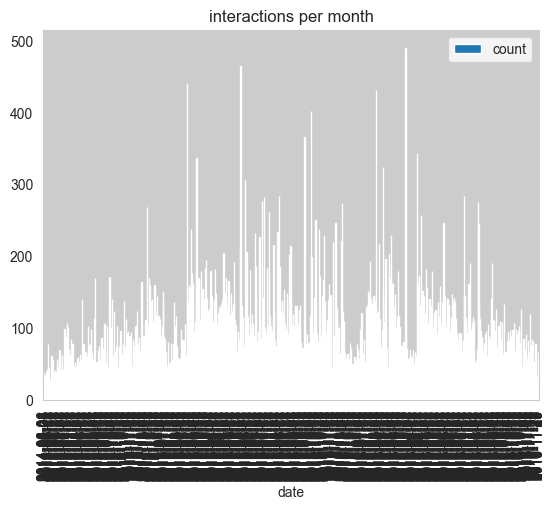

In [6]:
data = load_data_print_info(namepaths['data_path'])


STAGE -> getBucketsHoldouts
Creating buckets. . .
Creating holdouts. . .
Cleaning holdouts. . .
common interactions between holdout 1 and all buckets: 160
common interactions between holdout 2 and all buckets: 245
common interactions between holdout 3 and all buckets: 227
common interactions between holdout 4 and all buckets: 176
common interactions between holdout 5 and all buckets: 99
Converting to ImplicitData. . .
Done!

Bucket size, number of users, number of items
 [(9603, 2526, 7741), (16302, 4942, 12651), (15552, 4019, 12047), (12721, 3078, 10330), (10564, 2599, 8945)]
Holdouts size, number of users, number of items
 [(1363, 1363, 1285), (3567, 3567, 3170), (5340, 5340, 4563), (5967, 5967, 5112), (5324, 5324, 4554)]


STAGE -> to_grid_search
num_factors, num_iter, learn_rate, regularization
 (100, 6, 0.1, 0.1)


STAGE -> ISGD model


STAGE -> EvaluateHoldouts
----------------------------------------------------------------------------------------------------
Train bucket 0
Tes

FileNotFoundError: [Errno 2] No such file or directory: 'images/heatmaps/amazon_digmusic_dump/sample_2014-06_until_2016-11+cold_start_amazon_digitalmusic semesterly_bucket ISGD heatmap.png'

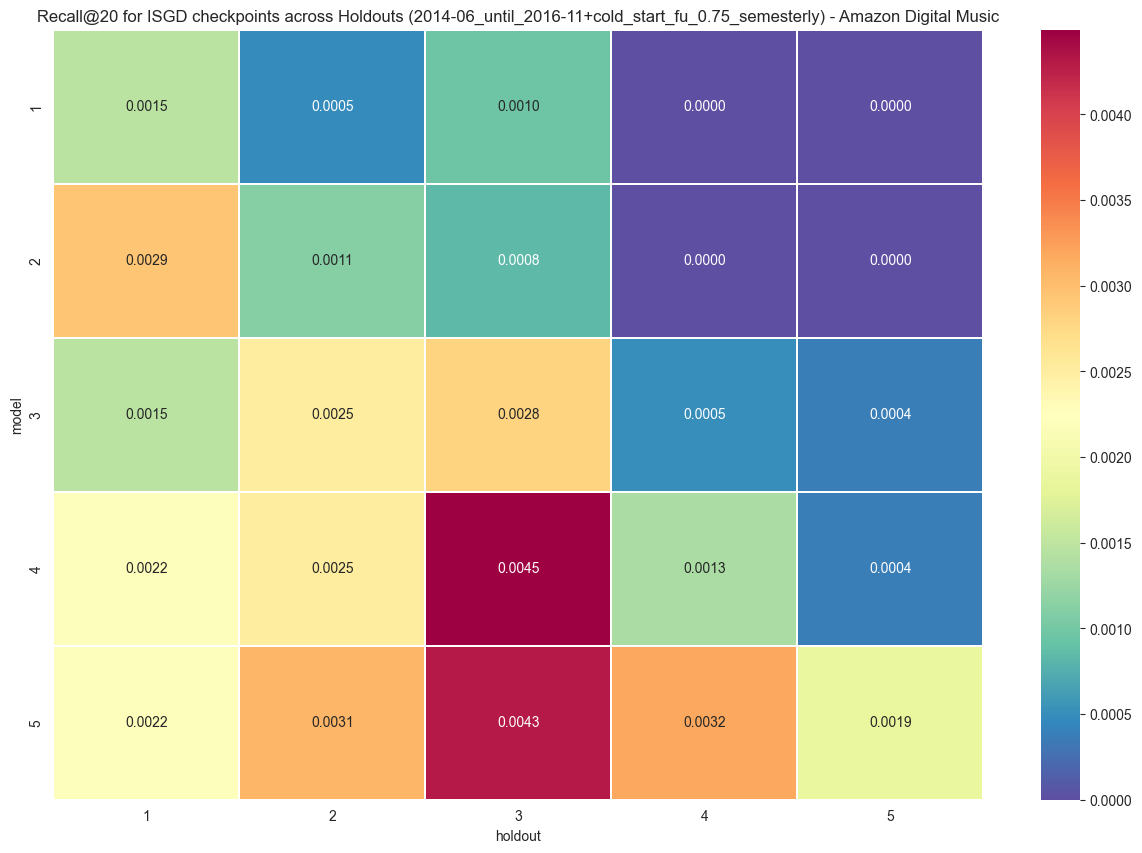

In [7]:
run_evaluate(data = data,
             user_col = namepaths['user_col'],
             item_col = namepaths['item_col'],
             interval_type = namepaths['interval_type'],
             intervals_path = namepaths['intervals_path'],
             use_data_unique_users = namepaths['use_data_unique_users'],
             frequent_users_path = namepaths['frequent_users_path'],
             buckets_path = namepaths['buckets_path'],
             holdouts_path = namepaths['holdouts_path'],
             cold_start_buckets = 0,
             to_grid_search = namepaths['to_grid_search'],
             num_factors = namepaths['num_factors'],
             num_iter = namepaths['num_iter'],
             learn_rate = namepaths['learn_rate'],
             regularization = namepaths['regularization'],
             random_seed = namepaths['random_seed'],
             results_matrix_path = namepaths['results_matrix_path'],
             recall_heatmap_title = namepaths['recall_heatmap_title'],
             recall_heatmap_path = namepaths['recall_heatmap_path'],
             incrementalTraining_time_record_path = namepaths['incrementalTraining_time_record_path'],
             evaluateHoldouts_time_record_path = namepaths['evaluateHoldouts_time_record_path'])


STAGE -> getBucketsHoldouts
Creating buckets. . .
Creating holdouts. . .
cold start bucket
Cleaning holdouts. . .
common interactions between holdout 1 and all buckets: 245
common interactions between holdout 2 and all buckets: 227
common interactions between holdout 3 and all buckets: 176
common interactions between holdout 4 and all buckets: 99
Converting to ImplicitData. . .
Done!

Bucket size, number of users, number of items
 [(10966, 2526, 8792), (16302, 4942, 12651), (15552, 4019, 12047), (12721, 3078, 10330), (10564, 2599, 8945)]
Holdouts size, number of users, number of items
 [(3567, 3567, 3170), (5340, 5340, 4563), (5967, 5967, 5112), (5324, 5324, 4554)]


STAGE -> to_grid_search
num_factors, num_iter, learn_rate, regularization
 (100, 6, 0.1, 0.1)


STAGE -> ISGD model


STAGE -> EvaluateHoldouts
----------------------------------------------------------------------------------------------------
Train bucket 0
---------------------------------------------------------------

(          0         1         2         3
 0  0.003364  0.000839  0.000213  0.000000
 1  0.005046  0.001685  0.000670  0.000376
 2  0.003925  0.003745  0.001843  0.000751
 3  0.004486  0.004682  0.003184  0.002630,
 0.002380659766510106,
 ([0.0016820857863751055, 0.001310310177878997, 0.0018194508096527247],
  0.0016039489246356092),
 (0.001626843095181879,
  [0.0016820857863751055,
   0.0005606952621250352,
   0.002059925093632959,
   0.0011213905242500703,
   0.00299625468164794,
   0.0013407072230601643]),
 0.0004749176476431226)

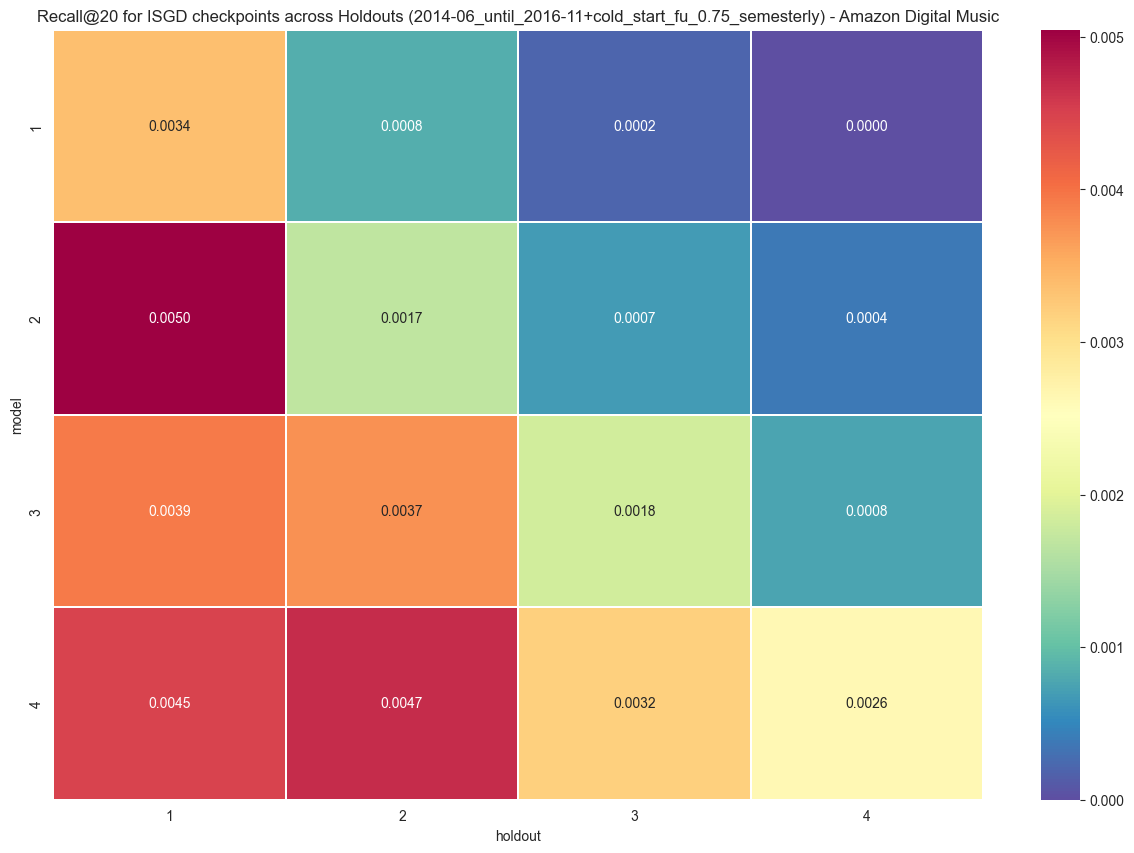

In [8]:
run_evaluate(data = data,
             user_col = namepaths['user_col'],
             item_col = namepaths['item_col'],
             interval_type = namepaths['interval_type'],
             intervals_path = namepaths['intervals_path'],
             use_data_unique_users = namepaths['use_data_unique_users'],
             frequent_users_path = namepaths['frequent_users_path'],
             buckets_path = namepaths['buckets_path'],
             holdouts_path = namepaths['holdouts_path'],
             cold_start_buckets = 1,
             to_grid_search = namepaths['to_grid_search'],
             num_factors = namepaths['num_factors'],
             num_iter = namepaths['num_iter'],
             learn_rate = namepaths['learn_rate'],
             regularization = namepaths['regularization'],
             random_seed = namepaths['random_seed'],
             results_matrix_path = namepaths['results_matrix_path'],
             recall_heatmap_title = namepaths['recall_heatmap_title'],
             recall_heatmap_path = namepaths['recall_heatmap_path'],
             incrementalTraining_time_record_path = namepaths['incrementalTraining_time_record_path'],
             evaluateHoldouts_time_record_path = namepaths['evaluateHoldouts_time_record_path'])

# positive rates

data.shape (80660, 4)
number of users 7353
number of items 52849
number of duplicated user-item interactions 3234

           user_id     item_id   timestamp        date
0  A1G1PWJWIVW6UR  B005OFVNTS  1401580800  2014-06-01
1   AQ4B80F0JSBNI  B002B8ZS0Q  1401580800  2014-06-01
2  A3GYWZE27QBMY7  B003RO1N98  1401580800  2014-06-01
3  A2HXYN2R7W1UQW  B000NNB2PG  1401580800  2014-06-01
4   APKXB8GFNRKEF  B000AOAA74  1401580800  2014-06-01


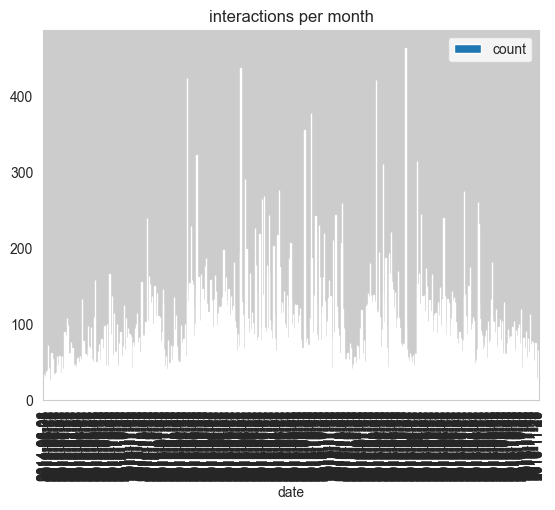

In [6]:
data_pos_rates = load_data_print_info(namepaths['output_path']+'sample_2014-06_until_2016-11+cold_start_positive_rates_amazon_digitalmusic.csv')


STAGE -> getBucketsHoldouts
Creating buckets. . .
Creating holdouts. . .
cold start bucket
Cleaning holdouts. . .
common interactions between holdout 1 and all buckets: 237
common interactions between holdout 2 and all buckets: 223
common interactions between holdout 3 and all buckets: 173
common interactions between holdout 4 and all buckets: 96
Converting to ImplicitData. . .
Done!

Bucket size, number of users, number of items
 [(10212, 2451, 8269), (15066, 4741, 11800), (14530, 3922, 11312), (11743, 2979, 9592), (9811, 2468, 8359)]
Holdouts size, number of users, number of items
 [(3382, 3382, 3044), (5079, 5079, 4383), (5730, 5730, 4952), (5107, 5107, 4401)]


STAGE -> to_grid_search
num_factors, num_iter, learn_rate, regularization
 (100, 6, 0.1, 0.1)


STAGE -> ISGD model


STAGE -> EvaluateHoldouts
----------------------------------------------------------------------------------------------------
Train bucket 0
-----------------------------------------------------------------

(          0         1         2         3
 0  0.002070  0.000444  0.000677  0.000263
 1  0.002070  0.002756  0.000878  0.000794
 2  0.001774  0.003741  0.001396  0.000588
 3  0.001183  0.004332  0.002618  0.001371,
 0.0018982643959292956,
 ([0.0, 0.0003443813646222912, 0.0006365682055118803], 0.0003269831900447238),
 (0.00043307789096337055,
  [0.0,
   -0.0002956830277942048,
   0.0009844457570387872,
   -0.000887049083382614,
   0.0015751132112620594,
   0.0012216404886561956]),
 0.0006072813440512957)

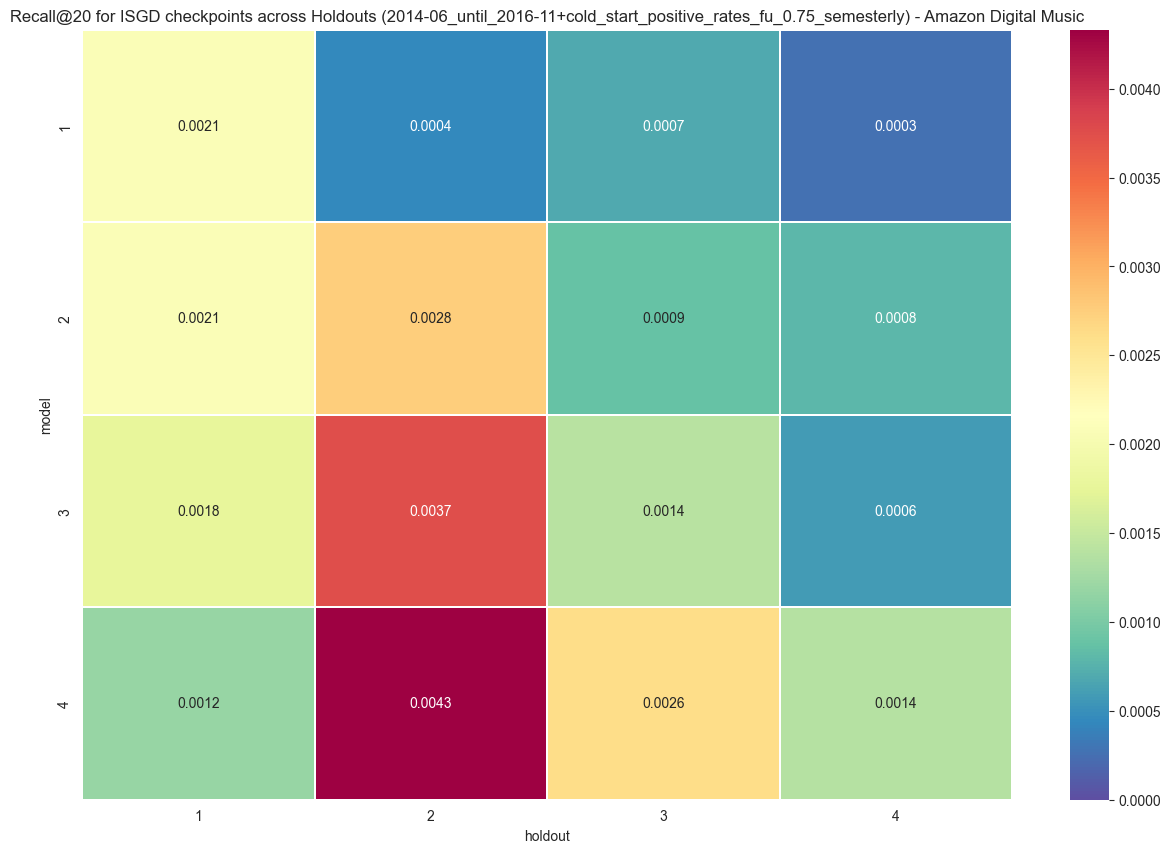

In [9]:
run_evaluate(data = data_pos_rates,
             user_col = namepaths['user_col'],
             item_col = namepaths['item_col'],
             interval_type = namepaths['interval_type'],
             intervals_path = namepaths['intervals_path'],
             use_data_unique_users = namepaths['use_data_unique_users'],
             frequent_users_path = namepaths['output_path']+'sample_2014-06_until_2016-11+cold_start_positive_rates_frequent_users_0.75.joblib',
             buckets_path = namepaths['output_path']+'sample_2014-06_until_2016-11+cold_start_positive_rates_fu_0.75_semesterly_buckets.joblib',
             holdouts_path = namepaths['output_path']+'sample_2014-06_until_2016-11+cold_start_positive_rates_fu_0.75_semesterly_holdouts.joblib',
             cold_start_buckets = 1,
             to_grid_search = namepaths['to_grid_search'],
             num_factors = namepaths['num_factors'],
             num_iter = namepaths['num_iter'],
             learn_rate = namepaths['learn_rate'],
             regularization = namepaths['regularization'],
             random_seed = namepaths['random_seed'],
             results_matrix_path = namepaths['output_path']+'sample_2014-06_until_2016-11+cold_start_positive_rates_amazon_digitalmusic semesterly_bucket ISGD results.csv',
             recall_heatmap_title = 'Recall@20 for ISGD checkpoints across Holdouts (2014-06_until_2016-11+cold_start_positive_rates_fu_0.75_semesterly) - Amazon Digital Music',
             recall_heatmap_path = 'images/heatmaps/amazon_digmusic_dump/sample_2014-06_until_2016-11+cold_start_positive_rates_amazon_digitalmusic semesterly_bucket ISGD heatmap.png',
             incrementalTraining_time_record_path = namepaths['output_path']+'sample_2014-06_until_2016-11+cold_start_positive_rates_amazon_digitalmusic semesterly_bucket ISGD training time.joblib',
             evaluateHoldouts_time_record_path = namepaths['output_path']+'sample_2014-06_until_2016-11+cold_start_positive_rates_amazon_digitalmusic semesterly_bucket ISGD eval time.joblib')

In [7]:
run_evaluate(data = data_pos_rates,
             user_col = namepaths['user_col'],
             item_col = namepaths['item_col'],
             interval_type = namepaths['interval_type'],
             intervals_path = namepaths['intervals_path'],
             use_data_unique_users = namepaths['use_data_unique_users'],
             frequent_users_path = namepaths['output_path']+'sample_2014-06_until_2016-11+cold_start_positive_rates_frequent_users_0.75.joblib',
             buckets_path = namepaths['output_path']+'sample_2014-06_until_2016-11+cold_start_positive_rates_fu_0.75_semesterly_buckets.joblib',
             holdouts_path = namepaths['output_path']+'sample_2014-06_until_2016-11+cold_start_positive_rates_fu_0.75_semesterly_holdouts.joblib',
             cold_start_buckets = 1,
             to_grid_search = namepaths['to_grid_search'],
             num_factors = namepaths['num_factors'],
             num_iter = namepaths['num_iter'],
             learn_rate = namepaths['learn_rate'],
             regularization = namepaths['regularization'],
             random_seed = namepaths['random_seed'],
             results_matrix_path = namepaths['output_path']+'sample_2014-06_until_2016-11+cold_start_positive_rates_amazon_digitalmusic semesterly_bucket ISGD results.csv',
             recall_heatmap_title = 'Recall@20 for ISGD checkpoints across Holdouts (2014-06_until_2016-11+cold_start_positive_rates_fu_0.75_semesterly) - Amazon Digital Music',
             recall_heatmap_path = 'images/heatmaps/amazon_digmusic_dump/sample_2014-06_until_2016-11+cold_start_positive_rates_amazon_digitalmusic semesterly_bucket ISGD heatmap.png',
             incrementalTraining_time_record_path = namepaths['output_path']+'sample_2014-06_until_2016-11+cold_start_positive_rates_amazon_digitalmusic semesterly_bucket ISGD training time.joblib',
             evaluateHoldouts_time_record_path = namepaths['output_path']+'sample_2014-06_until_2016-11+cold_start_positive_rates_amazon_digitalmusic semesterly_bucket ISGD eval time.joblib')


STAGE -> getBucketsHoldouts
Creating buckets. . .
Creating holdouts. . .
cold start bucket
Cleaning holdouts. . .
common interactions between holdout 1 and all buckets: 237
common interactions between holdout 2 and all buckets: 223
common interactions between holdout 3 and all buckets: 173
common interactions between holdout 4 and all buckets: 96
Converting to ImplicitData. . .
Done!

Bucket size, number of users, number of items
 [(10212, 2451, 8269), (15066, 4741, 11800), (14530, 3922, 11312), (11743, 2979, 9592), (9811, 2468, 8359)]
Holdouts size, number of users, number of items
 [(3382, 3382, 3044), (5079, 5079, 4383), (5730, 5730, 4952), (5107, 5107, 4401)]


STAGE -> to_grid_search
num_factors, num_iter, learn_rate, regularization
 (100, 6, 0.1, 0.1)


STAGE -> ISGD model


STAGE -> EvaluateHoldouts
----------------------------------------------------------------------------------------------------
Train bucket 0
-----------------------------------------------------------------

KeyboardInterrupt: 